# Train AMC Model
This notebook will develop and train a neural network to predict the percent change in the AMC price.
It will utilize grid search to find the best hyperparameters

## Enviornment setups

In [1]:
# Import packages

# General Utility
from datetime import datetime
import datetime, time
from datetime import timedelta

# Data processing
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import RobustScaler

# Plotting
import matplotlib.pyplot as plt

import torch

# Diamond-Hands
import sys
sys.path.append('../Packages/')
import diamond_hands as dh

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
tickr = 'AMC'

In [3]:
# Data Locations
processed_input_dir = '../../Data/ProcessedInputs/'
model_dir = '../../Data/Models/'
grid_result_dir = model_dir+tickr+'/'
fine_grid_result_dir = model_dir+tickr+'/Fine/'
pred_dir = '../../Data/Predictions/'
final_model_dir = '../../Data/Models/Final/'

In [4]:
TRAIN_ON_GPU, TRAIN_ON_MULTI_GPUS = dh.setupPytorch()

Training on 4 GPUs!


In [5]:
with open(processed_input_dir+tickr+'_input_data.bin','rb') as f:
    df = pickle.load(f)
with open(processed_input_dir+tickr+'_output_data.bin','rb') as f:
    output_data = pickle.load(f)
with open(model_dir+tickr+'_scaler.bin','rb') as f:
    scaler = pickle.load(f)

In [6]:
df = df[:-1]

In [7]:
df['2021-03-01':]

,P_Change,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,...,Tomorrow_Tickr_#Pos,Tomorrow_Tickr_W#Neg,Tomorrow_Tickr_W#Neu,Tomorrow_Tickr_W#Pos,Tomorrow_Tickr_%Neg,Tomorrow_Tickr_%Neu,Tomorrow_Tickr_%Pos,Tomorrow_Tickr_W%Neg,Tomorrow_Tickr_W%Neu,Tomorrow_Tickr_W%Pos
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,0.996412,-4.231264,61.938061,-0.812518,526.090051,1.371717,0.018810,0.041623,399.033166,-4.211420,...,174.0,124.0,2419.0,1073.0,0.079710,0.605072,0.315217,0.030437,0.593765,0.263378
2021-03-02,-0.655423,-4.301817,60.123806,-0.442206,437.413112,1.345195,0.000972,0.045076,459.428178,-4.220264,...,242.0,257.0,2176.0,1259.0,0.095779,0.511364,0.392857,0.061720,0.522574,0.302354
2021-03-03,-2.465973,-4.969614,58.837506,-0.485432,361.504404,1.208720,-0.006655,0.041040,-104.713880,-4.232645,...,63.0,101.0,403.0,406.0,0.091503,0.496732,0.411765,0.098633,0.393555,0.396484
2021-03-04,-0.649694,-5.004030,57.031130,-0.563422,280.244349,1.147646,-0.046334,0.034464,-174.353620,-4.232645,...,65.0,84.0,475.0,369.0,0.086957,0.509317,0.403727,0.088421,0.500000,0.388421
2021-03-05,1.755959,-4.703980,58.418215,-0.321317,241.035639,1.043844,-0.004343,0.033021,-117.843121,-4.231889,...,34.0,59.0,800.0,195.0,0.062992,0.669291,0.267717,0.049831,0.675676,0.164696
2021-03-08,3.141836,-3.461460,61.076621,0.003065,304.865361,1.080232,0.041207,0.040398,433.193034,-4.231889,...,117.0,223.0,1432.0,769.0,0.099338,0.513245,0.387417,0.083147,0.533930,0.286726
2021-03-09,5.512575,-1.898502,64.541736,0.212271,386.296660,1.188346,0.048751,0.051139,903.015375,-4.231889,...,276.0,958.0,6737.0,3950.0,0.082544,0.543978,0.373478,0.080376,0.565232,0.331404
2021-03-10,-1.058606,-5.093068,58.550336,-0.084805,215.020928,1.263475,0.048704,0.058255,84.371588,-4.231889,...,278.0,1882.0,5109.0,5481.0,0.147327,0.490222,0.362451,0.142619,0.387163,0.415353
2021-03-11,-1.450640,-5.385510,60.501759,-0.021986,209.316201,1.164494,-0.029796,0.053873,-299.710128,-4.218606,...,79.0,85.0,748.0,466.0,0.101604,0.475936,0.422460,0.060671,0.533904,0.332620


In [8]:
n_test=37

## Grid Search

In [9]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [1,5,10,20,40,60]
n_hidden = [10,50,100]
n_layers = [2,3]
drop_prob = [0.1,0.25,0.5]
lr = [0.001,0.01]
clip = [1,5,10]
batch_size = [400]

In [10]:
# use grid search to optimize hyperparameters
grid_result = []
dh.gridSearch(grid_results = grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=10,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 648 different configurations.
Iteration: 1 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1


C:\Environments\python37\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Training complete in 0m 26s
Iteration: 2 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 3 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 5s
Iteration: 4 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 6s
Iteration: 5 |periods: 40|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 8s
Iteration: 6 |periods: 60|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 11s
Iteration: 7 |periods: 1|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 3s
Iteration: 8 |periods: 5|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 9 |periods: 10|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 4s
Iteration: 10 |periods: 20|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 6s
Iteration: 11 |periods: 40|hidden: 50|layers: 2|drop: 0

Training complete in 0m 6s
Iteration: 81 |periods: 10|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 7s
Iteration: 82 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 9s
Iteration: 83 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 13s
Iteration: 84 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 17s
Iteration: 85 |periods: 1|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 6s
Iteration: 86 |periods: 5|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 7s
Iteration: 87 |periods: 10|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 8s
Iteration: 88 |periods: 20|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 11s
Iteration: 89 |periods: 40|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 14s
Iteration: 90 |periods: 60|hidden: 100|

Training complete in 0m 8s
Iteration: 160 |periods: 20|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 9s
Iteration: 161 |periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 15s
Iteration: 162 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 19s
Iteration: 163 |periods: 1|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 6s
Iteration: 164 |periods: 5|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 8s
Iteration: 165 |periods: 10|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 10s
Iteration: 166 |periods: 20|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 13s
Iteration: 167 |periods: 40|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 19s
Iteration: 168 |periods: 60|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 25s
Iteration: 169 |periods: 1|hid

Training complete in 0m 11s
Iteration: 239 |periods: 40|hidden: 10|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 18s
Iteration: 240 |periods: 60|hidden: 10|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 25s
Iteration: 241 |periods: 1|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 6s
Iteration: 242 |periods: 5|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 7s
Iteration: 243 |periods: 10|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 9s
Iteration: 244 |periods: 20|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 12s
Iteration: 245 |periods: 40|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 20s
Iteration: 246 |periods: 60|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 27s
Iteration: 247 |periods: 1|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 6s
Iteration: 248 |periods: 5|hidden

Training complete in 0m 19s
Iteration: 318 |periods: 60|hidden: 50|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 26s
Iteration: 319 |periods: 1|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 5s
Iteration: 320 |periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 8s
Iteration: 321 |periods: 10|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 10s
Iteration: 322 |periods: 20|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 14s
Iteration: 323 |periods: 40|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 22s
Iteration: 324 |periods: 60|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 29s
Iteration: 325 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 5s
Iteration: 326 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 6s
Iteration: 327 |periods: 10|hid

Training complete in 0m 29s
Iteration: 397 |periods: 1|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 5s
Iteration: 398 |periods: 5|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 6s
Iteration: 399 |periods: 10|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 7s
Iteration: 400 |periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 9s
Iteration: 401 |periods: 40|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 12s
Iteration: 402 |periods: 60|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 16s
Iteration: 403 |periods: 1|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 5s
Iteration: 404 |periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 6s
Iteration: 405 |periods: 10|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 7s
Iteration: 406 |periods: 20|hidden: 50|layers: 

Training complete in 0m 5s
Iteration: 476 |periods: 5|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 7s
Iteration: 477 |periods: 10|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 7s
Iteration: 478 |periods: 20|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 9s
Iteration: 479 |periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 13s
Iteration: 480 |periods: 60|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 16s
Iteration: 481 |periods: 1|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 5s
Iteration: 482 |periods: 5|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 6s
Iteration: 483 |periods: 10|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 8s
Iteration: 484 |periods: 20|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 10s
Iteration: 485 

Training complete in 0m 6s
Iteration: 554 |periods: 5|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 7s
Iteration: 555 |periods: 10|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 9s
Iteration: 556 |periods: 20|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 11s
Iteration: 557 |periods: 40|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 15s
Iteration: 558 |periods: 60|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 20s
Iteration: 559 |periods: 1|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 6s
Iteration: 560 |periods: 5|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 7s
Iteration: 561 |periods: 10|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 9s
Iteration: 562 |periods: 20|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 13s
Iteration: 563 |periods: 40|hid

Training complete in 0m 7s
Iteration: 633 |periods: 10|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 9s
Iteration: 634 |periods: 20|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 12s
Iteration: 635 |periods: 40|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 19s
Iteration: 636 |periods: 60|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 26s
Iteration: 637 |periods: 1|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 6s
Iteration: 638 |periods: 5|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 8s
Iteration: 639 |periods: 10|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 10s
Iteration: 640 |periods: 20|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 14s
Iteration: 641 |periods: 40|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 20s
Iteration: 642 |periods: 60|hidde

In [11]:
with open(model_dir+tickr+'_grid_search_result.bin','wb') as f:
    pickle.dump(grid_result,f)

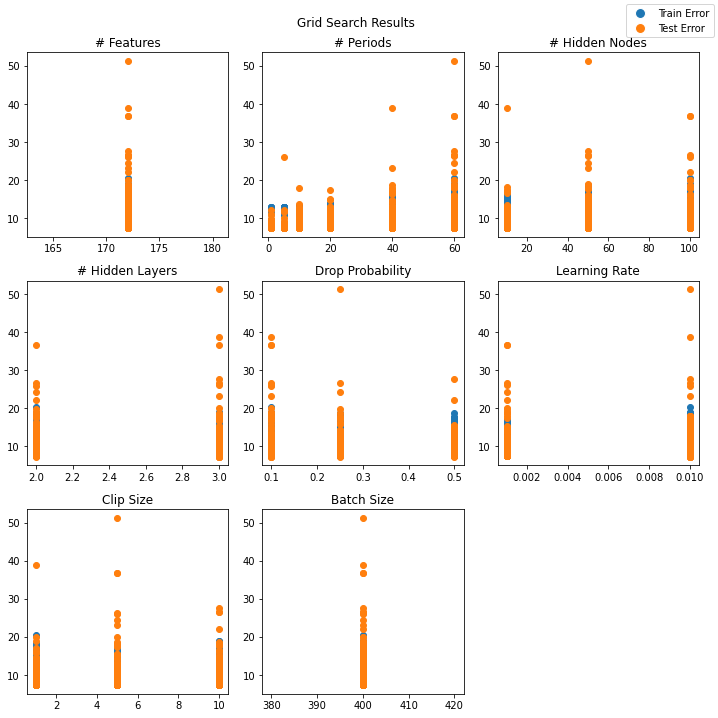

In [12]:
dh.visualizeGridSearch(grid_result)

In [13]:
resultdf = dh.resultDF(grid_result)

In [14]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size
619,12.260847,7.236698,172.0,5.0,50.0,2.0,0.50,0.010,10.0,400.0
134,12.574904,7.292650,172.0,10.0,50.0,3.0,0.10,0.010,1.0,400.0
172,14.679902,7.342018,172.0,40.0,50.0,3.0,0.25,0.010,1.0,400.0
349,12.145816,7.346291,172.0,5.0,50.0,3.0,0.10,0.010,5.0,400.0
139,11.821330,7.350876,172.0,5.0,100.0,3.0,0.10,0.010,1.0,400.0
...,...,...,...,...,...,...,...,...,...,...
641,16.616180,27.696283,172.0,60.0,50.0,3.0,0.50,0.010,10.0,400.0
233,15.949228,36.738804,172.0,60.0,100.0,2.0,0.10,0.001,5.0,400.0
251,16.141391,36.767666,172.0,60.0,100.0,3.0,0.10,0.001,5.0,400.0
130,14.307155,38.875141,172.0,40.0,10.0,3.0,0.10,0.010,1.0,400.0


## Fine Grid Search

In [15]:
best_model_id = sorted_results.index[0]

In [16]:
with open(grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()


StockLSTM(
  (lstm): LSTM(172, 50, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=250, out_features=1, bias=True)
)

In [17]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [model.n_periods]
n_hidden = [model.n_hidden]
n_layers = [model.n_layers]
drop_prob = [model.drop_prob]
lr = [model.lr]
clip = [model.clip]
#batch_size = [1,5,10,20,40,60,120,240]
batch_size = [4,20,40,80,240,480,960]
epochs = [10,25,50,100,250,500]

In [19]:
batch_size = [20,40,80,240,480,960]
epochs = [250,500]

In [20]:
# use fine grid search to optimize hyperparameters
#fine_grid_result = []
dh.finegridSearch(grid_results = fine_grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=epochs,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=fine_grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 12 different configurations.
Iteration: 1 |epochs: 250|periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 45m 34s
Iteration: 2 |epochs: 250|periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 22m 60s
Iteration: 3 |epochs: 250|periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 11m 48s
Iteration: 4 |epochs: 250|periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 4m 20s
Iteration: 5 |epochs: 250|periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 2m 26s
Iteration: 6 |epochs: 250|periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 1m 30s
Iteration: 7 |epochs: 500|periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 74m 21s
Iteration: 8 |epochs: 500|periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 34m 28s
Iteration: 9 |epochs: 50

In [21]:
with open(model_dir+tickr+'fine_grid_search_result.bin','wb') as f:
    pickle.dump(fine_grid_result,f)

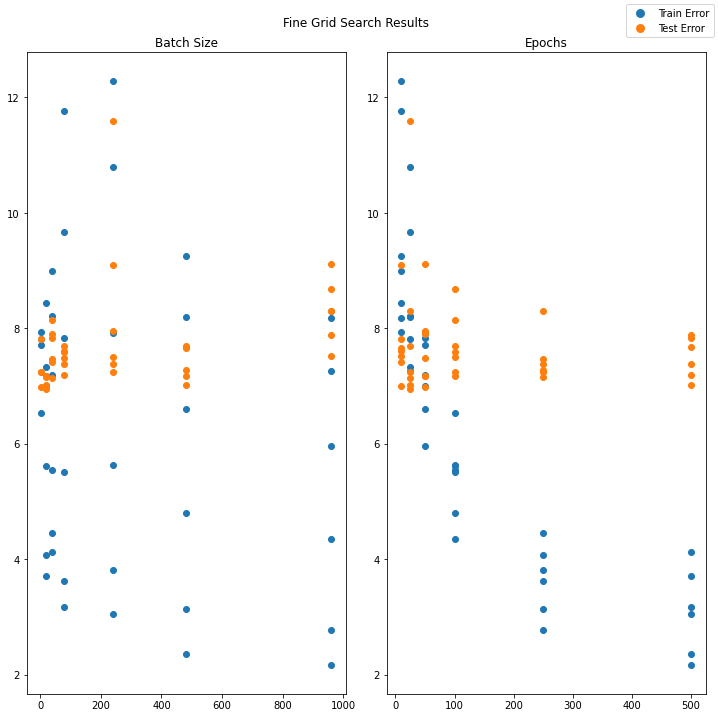

In [22]:
dh.visualizeFineGridSearch(fine_grid_result)

In [23]:
resultdf = dh.resultDFFine(fine_grid_result)

In [24]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size,Epochs
8,7.335174,6.956551,172.0,5.0,50.0,2.0,0.5,0.01,10.0,20.0,25.0
14,7.719404,6.987856,172.0,5.0,50.0,2.0,0.5,0.01,10.0,4.0,50.0
1,8.442473,7.008166,172.0,5.0,50.0,2.0,0.5,0.01,10.0,20.0,10.0
34,3.716538,7.016989,172.0,5.0,50.0,2.0,0.5,0.01,10.0,20.0,500.0
12,8.198156,7.027387,172.0,5.0,50.0,2.0,0.5,0.01,10.0,480.0,25.0
9,8.223330,7.147090,172.0,5.0,50.0,2.0,0.5,0.01,10.0,40.0,25.0
28,4.083522,7.150361,172.0,5.0,50.0,2.0,0.5,0.01,10.0,20.0,250.0
19,6.597075,7.174539,172.0,5.0,50.0,2.0,0.5,0.01,10.0,480.0,50.0
15,7.005751,7.179006,172.0,5.0,50.0,2.0,0.5,0.01,10.0,20.0,50.0
22,5.610409,7.183541,172.0,5.0,50.0,2.0,0.5,0.01,10.0,20.0,100.0


## Evaluate Final Model

In [25]:
best_model_id = sorted_results.index[0]
with open(fine_grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()

StockLSTM(
  (lstm): LSTM(172, 50, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=250, out_features=1, bias=True)
)

Training RMSE: 0.4160734198972411
Test RMSE: 0.8847130487181287
Training MAE: 0.3014279531057289
Test MAE: 0.6620077547896797
Training - Above Error: $0.28 (39.86%) Below Error: $-0.32 (60.14%)
Test - Above Error: $0.78 (40.54%) Below Error: $-0.58 (59.46%)


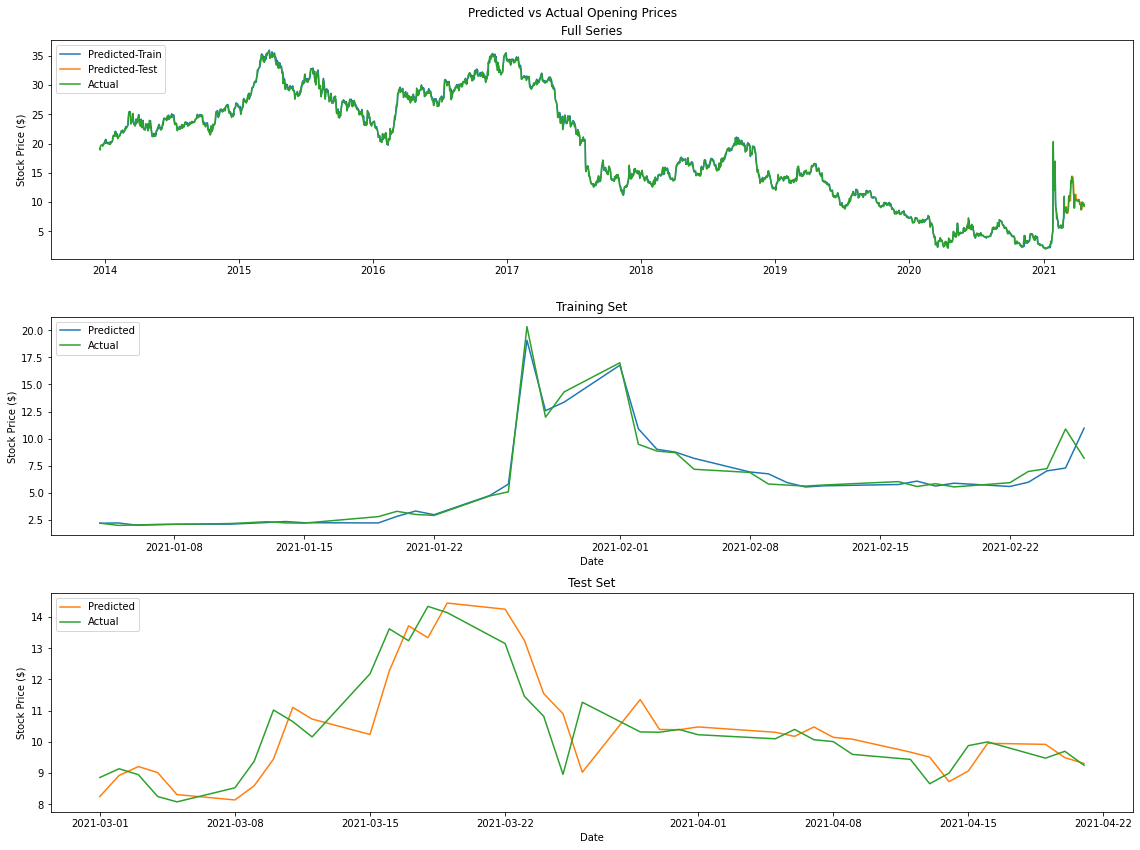

In [26]:
preds = dh.evaluateModel(model=model,
             input_data=df,
             output_data=output_data[:-1],
             scaler=scaler,
             n_steps_in=model.n_periods,
             n_steps_out=1,
             n_test=n_test)

In [27]:
preds.tail()

,Open,Raw_Predictions,Prediction_Type,Predicted
Date,,,,
2021-04-15,9.88,0.007616,Test,9.068542
2021-04-16,10.00,-0.007859,Test,9.955244
2021-04-19,9.48,0.001786,Test,9.921406
2021-04-20,9.70,-0.040340,Test,9.496926
2021-04-21,9.25,0.052376,Test,9.308699


In [28]:
with open(pred_dir+tickr+'_pred.bin','wb') as f:
    pickle.dump(preds,f)

In [29]:
with open(final_model_dir+tickr+'_model.model','wb') as f:
    torch.save(model,f)